In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os, time, copy 
import gc, json, random
from pathlib import Path

import itertools
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

# ............................................
import warnings
warnings.filterwarnings('ignore')
!ls ../input/*

../input/child-mind-institute-problematic-internet-use:
data_dictionary.csv    series_test.parquet   test.csv
sample_submission.csv  series_train.parquet  train.csv

../input/cmi-nkwon-1:
__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  train_sii.csv


In [2]:
dtrain = pd.read_csv('/kaggle/input/cmi-nkwon-1/train_sii.csv', index_col='id')
dtest = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col='id')
sub_sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

dtrain_col = dtrain.columns.tolist()
dtest_col = dtest.columns.tolist()

dtrain.shape, dtest.shape, sub_sample.shape

((3960, 81), (20, 58), (20, 2))

In [3]:
dtrain.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,3960.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.541162
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.735780
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


# Missing Values

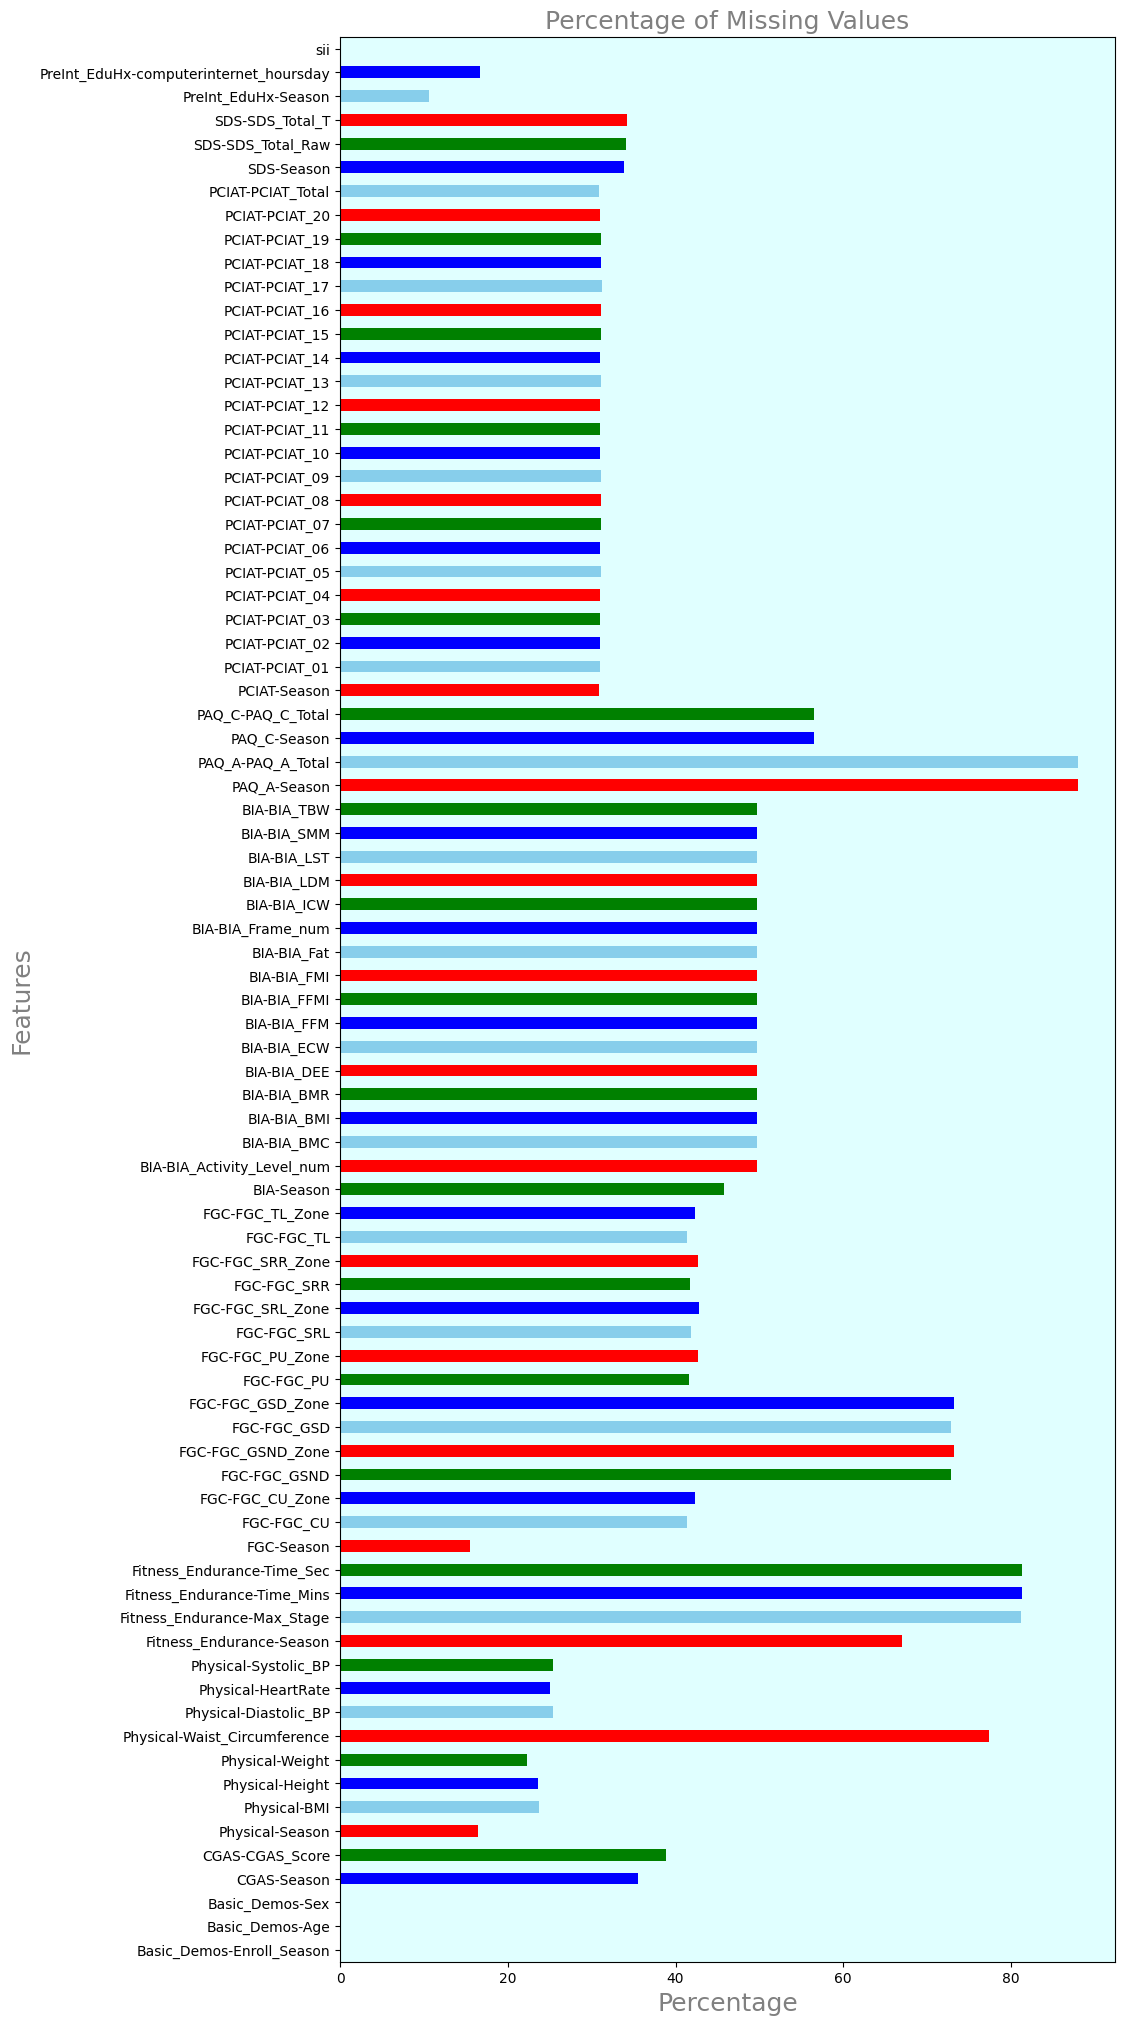

In [4]:
train = dtrain.copy()
test = dtest.copy()

train_col = train.columns.tolist()
test_col = test.columns.tolist()

missing_values = train.isnull().mean() * 100
missing_values.plot(kind='barh', figsize=(10, 25), color=['green','red','skyblue','blue'])

plt.title('Percentage of Missing Values', fontsize=18, color='gray')
plt.xlabel('Percentage', fontsize=18, color='gray')
plt.ylabel('Features', fontsize=18, color='gray')
plt.gca().set_facecolor('lightcyan')
plt.xticks(rotation=0)
plt.show();

# Features

In [5]:
features = test_col.copy()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if train[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))

# Target Features
target_col = [f for f in train_col if f not in test_col]
print('The number of target features :', len(target_col), '\n')
pd.DataFrame(data= {'Unique number in train': train[features].nunique(), 
                    'Unique number in test': test[features].nunique()}).sort_values(by=['Unique number in train']) 

Number of Features : 58
The number of numerical features : 47
The number of categorical features : 11
The number of target features : 23 



,Unique number in train,Unique number in test
Basic_Demos-Sex,2,2
FGC-FGC_SRL_Zone,2,2
FGC-FGC_TL_Zone,2,2
FGC-FGC_SRR_Zone,2,2
FGC-FGC_PU_Zone,2,2
FGC-FGC_CU_Zone,2,2
FGC-FGC_GSND_Zone,3,2
FGC-FGC_GSD_Zone,3,2
BIA-BIA_Frame_num,3,2
FGC-Season,4,4


# Features Imputation (for train & test)¶

In [6]:
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")

# .........................................................................
df_data = pd.concat([train[features], test], axis=0)

imputer_num.fit(df_data[num_features])
df_data[num_features] = imputer_num.transform(df_data[num_features])

for col in cat_features:
    df_data[col] = df_data[col].fillna('unknown')
    df_data[col] = df_data[col].astype('category')

# .........................................................................
df_data.shape, df_data.isnull().mean() * 100 

((3980, 58),
 Basic_Demos-Enroll_Season                 0.0
 Basic_Demos-Age                           0.0
 Basic_Demos-Sex                           0.0
 CGAS-Season                               0.0
 CGAS-CGAS_Score                           0.0
 Physical-Season                           0.0
 Physical-BMI                              0.0
 Physical-Height                           0.0
 Physical-Weight                           0.0
 Physical-Waist_Circumference              0.0
 Physical-Diastolic_BP                     0.0
 Physical-HeartRate                        0.0
 Physical-Systolic_BP                      0.0
 Fitness_Endurance-Season                  0.0
 Fitness_Endurance-Max_Stage               0.0
 Fitness_Endurance-Time_Mins               0.0
 Fitness_Endurance-Time_Sec                0.0
 FGC-Season                                0.0
 FGC-FGC_CU                                0.0
 FGC-FGC_CU_Zone                           0.0
 FGC-FGC_GSND                              0.0


# Pandas get_dummies & Preprocessing - Scaler (for train & test)

In [7]:
df_code = pd.get_dummies(df_data, columns=cat_features)

# ......................................................................
# StandardScaler
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_code[num_features] = scaler.fit_transform(df_code[num_features])

# ......................................................................
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_code[num_features] = scaler.fit_transform(df_code[num_features])

# ......................................................................
df_code.shape

(3980, 98)

# Time Series Aggregation¶
Time series statistics (e.g., mean, standard deviation) from the Actigraphy data are computed and merged into the main dataset to create additional features for model training.

In [8]:
from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [9]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


In [10]:
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

# .....................................................................................................................
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data

# .....................................................................................................................
train_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_ts = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')

# .....................................................................................................................
train_ts.shape, test_ts.shape, len(time_series_cols)

100%|██████████| 2/2 [00:00<00:00, 11.77it/s]


((996, 97), (2, 97), 96)

# Feature Engineering

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

# Preprocessing - Scaler (for time series)

In [12]:
#df_data_ts = pd.concat([train_ts, test_ts], axis=0)

# .........................................................................................
#StandardScaler
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#df_data_ts[time_series_cols] = scaler.fit_transform(df_data_ts[time_series_cols])

# .........................................................................................
# MinMaxScaler
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#df_data_ts[time_series_cols] = scaler.fit_transform(df_data_ts[time_series_cols])

# .........................................................................................
#df_data_ts.shape

# Data Setting

In [13]:
df_code = df_code.reset_index()

train_df = df_code[:3960].copy()
test_df = df_code[3960:].copy()

train_df.shape, test_df.shape, df_code.shape

((3960, 99), (20, 99), (3980, 99))

In [14]:
#train_ts = df_data_ts[:996].copy()
#test_ts = df_data_ts[996:].copy()
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]
train_ts_encoded.shape, test_ts_encoded.shape

Epoch [10/100], Loss: 1.6820]
Epoch [20/100], Loss: 1.5588]
Epoch [30/100], Loss: 1.5344]
Epoch [40/100], Loss: 1.5162]
Epoch [50/100], Loss: 1.4992]
Epoch [60/100], Loss: 1.4981]
Epoch [70/100], Loss: 1.4112]
Epoch [80/100], Loss: 1.4076]
Epoch [90/100], Loss: 1.3864]
Epoch [100/100], Loss: 1.3861]
Epoch [10/100], Loss: 1.0147]
Epoch [20/100], Loss: 0.7403]
Epoch [30/100], Loss: 0.4308]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


((996, 61), (2, 61))

In [15]:

train_df = pd.merge(train_df, train_ts_encoded, how="left", on='id')
test_df = pd.merge(test_df, test_ts_encoded, how="left", on='id')
train = feature_engineering(train_df)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test_df)

train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)  

featuresCols = ['Basic_Demos-Age',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

featuresCols += time_series_cols

train = train[featuresCols]

featuresCols = ['Basic_Demos-Age',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

featuresCols += time_series_cols
test = test[featuresCols]
# ..................................................................
#for col in time_series_cols:
    
    #train[col] = train[col].fillna(train[col].median())
    #test[col] = test[col].fillna(test[col].median())

# ..................................................................

train.shape, test.shape

((3960, 122), (20, 122))

# Features Correlation

In [16]:
df_corr = train_df.copy()
df_corr['sii'] = dtrain['sii'].values.copy()

# .............................................................
corr_sii = df_corr.corr(numeric_only=True)['sii']
corr_sii = corr_sii[(corr_sii > 0.02) | (corr_sii < -0.02)]

corr_list = corr_sii.keys().tolist()
corr_list.remove('sii')

len(corr_list)

117

In [17]:
y  = dtrain['sii'].copy()
X  = train_df[corr_list].copy()
XX = test_df[corr_list].copy()

y.shape, X.shape, XX.shape

((3960,), (3960, 117), (20, 117))

In [18]:
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
base_model = lgb.LGBMRegressor(random_state=420, verbose=-1)
print('\nr2_score :', cross_val_score(base_model, X ,y ,cv=5, scoring='r2')) 


r2_score : [0.24404461 0.29267947 0.26267018 0.31939784 0.21710557]


# Auxiliary Functions¶

In [20]:
def round_t(pred_raw, t):
    pred = np.where(pred_raw < t[0], 0, np.where(pred_raw < t[1], 1, np.where(pred_raw < t[2], 2, 3)))
    return pred

def qw_kappa(y_true, pred):
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

def fun(t, y_true, pred_raw):
    pred = round_t(pred_raw, t)
    return -cohen_kappa_score(y_true, pred, weights='quadratic')

def optimized_thresholds(fun, y_true, pred_raw):
    res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y_true, pred_raw), method='Nelder-Mead')
    assert res.success
    return res.x.round(2) # optimized_thresholds

t = [0.6, 1.07, 2.52] # Optimized Thresholds (initial)

# Hyperparameters

In [21]:
lgbm_params1 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.04,
    'max_depth'           : 12,
    'num_leaves'          : 59,
    'subsample'           : 0.70,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,    
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
    'device'              : 'gpu'
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params2 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.05,
    'max_depth'           : 9,
    'num_leaves'          : 59,
    'subsample'           : 0.80,
    'colsample_bytree'    : 0.50,
    'min_child_weight'    : 12, 
    'min_child_samples'   : 14,  
    'reg_alpha'           : 0.23,
    'reg_lambda'          : 0.36,
    'device'              : 'gpu'
}

# ::::::::::::::::::::::::::::::::::::::::::::::::
lgbm_params3 = {  
    
    'metric'              :'rmse',
    'objective'           :'regression',
    'learning_rate'       : 0.046,
    'max_depth'           : 12,
    'num_leaves'          : 478,
    'min_data_in_leaf'    : 13,
    'feature_fraction'    : 0.893,
    'bagging_fraction'    : 0.784,
    'bagging_freq'        : 4,
    'lambda_l1'           : 10, 
    'lambda_l2'           : 0.01, 
    'device'              : 'gpu'
}

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model1 = lgb.LGBMRegressor(**lgbm_params1, n_estimators=10000, random_state=421, early_stopping_rounds=350, verbose=-1)

model2 = lgb.LGBMRegressor(**lgbm_params2, n_estimators=10000, random_state=422, early_stopping_rounds=350, verbose=-1)

model3 = lgb.LGBMRegressor(**lgbm_params3, n_estimators=10000, random_state=423, early_stopping_rounds=350, verbose=-1)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

model_list = [model1, model2, model3]


# Detecting less important features¶

In [22]:
from lightgbm import plot_importance   
model_b = lgb.LGBMRegressor(**lgbm_params1, verbose=-1)
model_b.fit(X, y)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LGBMRegressor(colsample_bytree=0.5, device='gpu', learning_rate=0.04,
              max_depth=12, metric='rmse', min_child_samples=14,
              min_child_weight=12, num_leaves=59, objective='regression',
              reg_alpha=0.23, reg_lambda=0.36, subsample=0.7, verbose=-1)

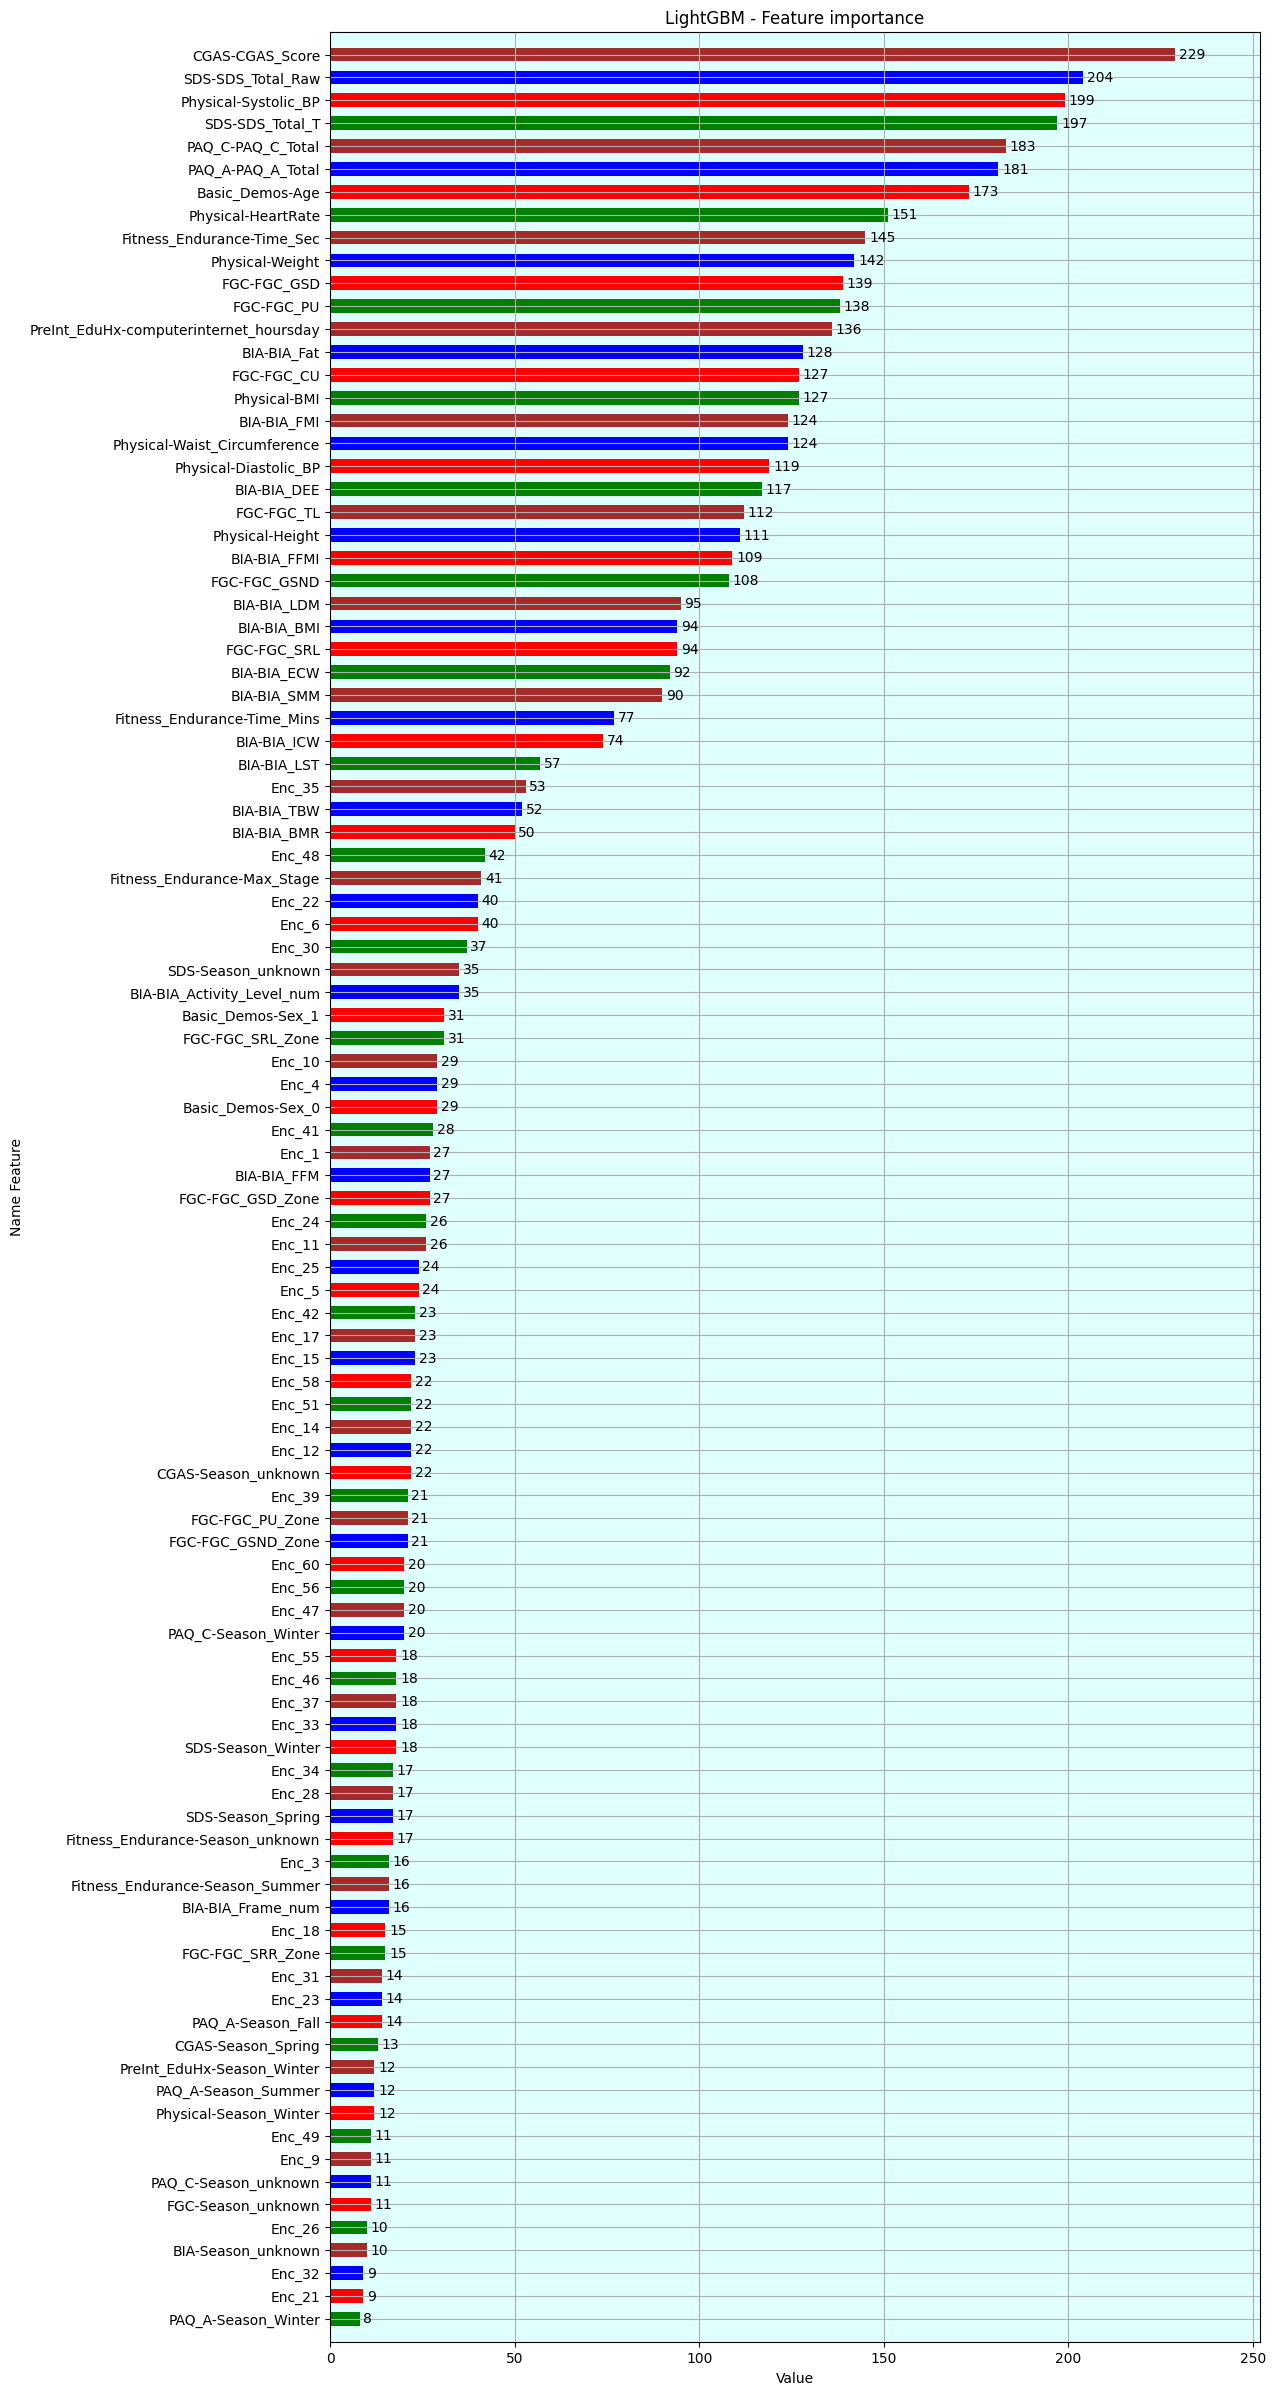

In [23]:
plot_importance(model_b, figsize=(12, 30), color=['green','red','blue','brown'], height=0.6, max_num_features=100,
                title='LightGBM - Feature importance', xlabel='Value', ylabel='Name Feature');

plt.gca().set_facecolor('lightcyan')

In [24]:
name_list = X.columns.tolist()
weight_list = model_b.feature_importances_ 

# ............................................................
name_weight = []
for i in range(len(name_list)):
    name_weight.append([name_list[i], weight_list[i]])
    
name_weight_sort = sorted(name_weight, key=lambda x: x[1])   

# ............................................................
print('Total number of features :', len(name_weight_sort))
weight_list, name_weight_sort[:10] 


Total number of features : 117


(array([173, 229, 127, 111, 142, 124, 119, 151, 199,  41,  77, 145, 127,
        108,  21, 139,  27, 138,  21,  94,  31,  15, 112,  35,  94,  50,
        117,  92,  27, 109, 124, 128,  16,  74,  95,  57,  90,  52, 181,
        183, 204, 197, 136,   5,   3,  29,  31,  13,  22,  12,   2,   2,
          3,  16,  17,   4,  11,   5,  10,  14,   1,  12,   8,   7,   2,
          2,  20,  11,  17,  18,  35,   7,  12,   3,  27,  16,  29,  24,
         40,  11,  29,  26,  22,   7,  22,  23,  23,  15,   9,  40,  14,
         26,  24,  10,   5,  17,  37,  14,   9,  18,  17,  53,  18,  21,
          2,  28,  23,   2,  18,  20,  42,  11,  22,  18,  20,  22,  20],
       dtype=int32),
 [['PAQ_A-Season_Spring', 1],
  ['Physical-Season_unknown', 2],
  ['Fitness_Endurance-Season_Fall', 2],
  ['PAQ_C-Season_Fall', 2],
  ['PAQ_C-Season_Spring', 2],
  ['Enc_40', 2],
  ['Enc_43', 2],
  ['Basic_Demos-Enroll_Season_Winter', 3],
  ['Fitness_Endurance-Season_Spring', 3],
  ['PreInt_EduHx-Season_unknown', 3]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
model_t = lgb.LGBMRegressor(**lgbm_params1, verbose=-1)

model_t.fit(X_train, y_train)
predict_t = model_t.predict(X_test)

score_t = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
print('Score based on all (', len(name_list), ') features :', score_t, '\n')

# .................................................................................................
X_t = X.copy()
XX_t = XX.copy()

for i in range(len(name_weight_sort)):
    
    name_i = name_weight_sort[i][0]
    weight_i = name_weight_sort[i][1]
    
    X_i = X_t.drop(columns=name_i, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, test_size=0.20, random_state=123)
    
    model_t.fit(X_train, y_train)
    predict_i = model_t.predict(X_test)
    
    score_i = cohen_kappa_score(y_test, round_t(predict_i, t), weights='quadratic')
    
    if (score_t < score_i):
        X_t.drop(columns=name_i, inplace=True)
        XX_t.drop(columns=name_i, inplace=True)
        score_t = score_i
        
        print('New Score :',round(score_i, 5), '| Weight :', weight_i, '| Name-deleted :', name_i)
    
# .................................................................................................
print('\nX_t Shape :', X_t.shape, 'XX_t Shape :', XX_t.shape) 

Score based on all ( 117 ) features : 0.5199927813035763 

New Score : 0.54129 | Weight : 1 | Name-deleted : PAQ_A-Season_Spring
New Score : 0.54195 | Weight : 2 | Name-deleted : PAQ_C-Season_Spring
New Score : 0.54948 | Weight : 9 | Name-deleted : Enc_32
New Score : 0.55896 | Weight : 18 | Name-deleted : Enc_46

X_t Shape : (3960, 113) XX_t Shape : (20, 113)


# Cross-validation¶

In [26]:
score_mean = 0
th = np.zeros(3)
pred = np.zeros(len(XX))
rkf = RepeatedKFold(n_splits=3, n_repeats=8, random_state=424)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(X)):  
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]  

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')
    N = random.randrange(4) 
         
    if (N==0):
        print('LGBMRegressor - 1')
        model1.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model1.predict(X_valid)
        prd = model1.predict(XX)
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
 
    if (N==1):
        print('LGBMRegressor - 2')
        model2.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])      
        oof = model2.predict(X_valid)
        prd = model2.predict(XX)
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
 
    if (N==2 or N==3):
        print('LGBMRegressor - 3')
        model3.fit(X_train, y_train,             
                  eval_set=[(X_valid, y_valid)])        
        oof = model3.predict(X_valid)
        prd = model3.predict(XX) 
        
        th_opt = optimized_thresholds(fun, y_valid, oof)
        print('th_opt =', th_opt)
    
    score = cohen_kappa_score(y_valid, round_t(oof, th_opt), weights='quadratic')
    print('SCORE:', round(score, 4))
    
    th += np.array(th_opt)                          
    score_mean += score 
    pred += prd
    
score_mean = score_mean / rkf.get_n_splits(X, y)   
t = np.round(th / rkf.get_n_splits(X, y), 2)
preds_lgbm_raw = pred / rkf.get_n_splits(X, y)
preds_lgbm = round_t(preds_lgbm_raw, t)

print('\n', '='* 40)
print(' .'* 20)
print(' SCORE(mean):', score_mean, '\n')
print(' Optimized thresholds:', t)
print(' .'* 20)
print('='* 40, '\n')


:::::::::::::::::: Fold ~ 1 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.5  1.49 2.51]
SCORE: 0.4569

:::::::::::::::::: Fold ~ 2 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.53 1.05 2.83]
SCORE: 0.4792

:::::::::::::::::: Fold ~ 3 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.57 0.91 2.84]
SCORE: 0.4924

:::::::::::::::::: Fold ~ 4 :::::::::::::::::::
LGBMRegressor - 1
th_opt = [0.45 1.51 2.59]
SCORE: 0.4664

:::::::::::::::::: Fold ~ 5 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.49 0.99 2.83]
SCORE: 0.507

:::::::::::::::::: Fold ~ 6 :::::::::::::::::::
LGBMRegressor - 1
th_opt = [0.49 1.34 2.66]
SCORE: 0.4397

:::::::::::::::::: Fold ~ 7 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.53 1.12 2.48]
SCORE: 0.5097

:::::::::::::::::: Fold ~ 8 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.57 1.1  2.68]
SCORE: 0.5137

:::::::::::::::::: Fold ~ 9 :::::::::::::::::::
LGBMRegressor - 3
th_opt = [0.5  1.59 2.48]
SCORE: 0.4365

:::::::::::::::::: Fold ~ 10 ::::::::

(0.044, 1.017)

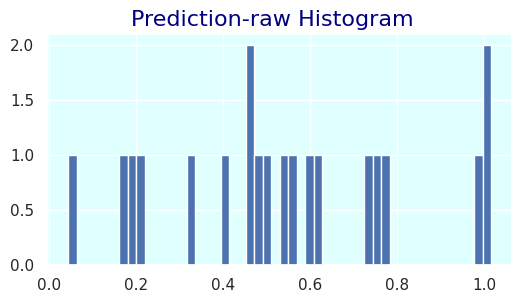

In [27]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_lgbm_raw, bins=50)

plt.gca().set_facecolor('lightcyan')
plt.suptitle('Prediction-raw Histogram', y=0.96, fontsize=16, c='navy')

round(min(preds_lgbm_raw), 3), round(max(preds_lgbm_raw), 3)

(0, 1)

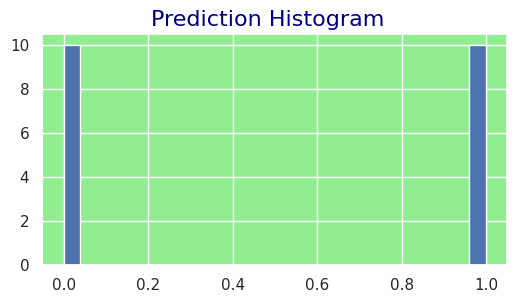

In [28]:
sns.set()
plt.figure(figsize=(6, 3))
plt.hist(preds_lgbm, bins=25)

plt.gca().set_facecolor('lightgreen')
plt.suptitle('Prediction Histogram', y=0.96, fontsize=16, c='navy')

min(preds_lgbm), max(preds_lgbm)

In [29]:
sub_lgbm = sub_sample.copy()
sub_lgbm['sii'] = preds_lgbm

# ............................................
# sub_lgbm.to_csv('submission.csv', index=False)
print(sub_lgbm['sii'].value_counts())
# Public Score : 
!ls

sii
1    10
0    10
Name: count, dtype: int64
__notebook__.ipynb


# LightGBM - Single Model

In [30]:
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.0101 ,
    'device'              : 'gpu'
}

# ...........................................................................................
model_lg = lgb.LGBMRegressor(**Params, random_state=420, verbose=-1, n_estimators=300)
model_lg.fit(X, y)             

preds_lg_raw = model_lg.predict(XX)
preds_lg = round_t(preds_lg_raw, t)

# ...........................................................................................
sub_lg = sub_sample.copy()
sub_lg['sii'] = preds_lg

# sub_lg.to_csv('submission.csv', index=False)
print(sub_lg['sii'].value_counts())
# Public Score : 
!ls

sii
0    11
1     9
Name: count, dtype: int64
__notebook__.ipynb


# XGBoost

In [31]:
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  
    'reg_lambda': 5,  
    'random_state': 42,
    'tree_method':'gpu_hist'
}

# ...........................................................................................
model_xgb = XGBRegressor(**XGB_Params)
model_xgb.fit(X, y)             

preds_xgb_raw = model_xgb.predict(XX)
preds_xgb = round_t(preds_xgb_raw, t)

# ...........................................................................................
sub_xgb = sub_sample.copy()
sub_xgb['sii'] = preds_xgb

# sub_xgb.to_csv('submission.csv', index=False)
print(sub_xgb['sii'].value_counts())
# Public Score : 
!ls

sii
1    10
0    10
Name: count, dtype: int64
__notebook__.ipynb


# catboost

In [32]:
X_c  = df_data[:3960].copy()
XX_c = df_data[3960:].copy()

# ...........................................................................................
features = X_c.columns.tolist()
print('Number of Features :', len(features))

# Numerical Features
num_features = [f for f in features if X_c[f].dtype==float or f=='Basic_Demos-Age']
print('The number of numerical features :', len(num_features))

# Categorical Features
cat_features = [f for f in features if f not in num_features]
print('The number of categorical features :', len(cat_features))

Number of Features : 58
The number of numerical features : 47
The number of categorical features : 11


In [33]:
CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 42,
    'cat_features': cat_features,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'GPU'
}

# ...........................................................................................
model_cat = CatBoostRegressor(**CatBoost_Params)
model_cat.fit(X_c, y) 

preds_cat_raw = model_cat.predict(XX_c)
preds_cat = round_t(preds_cat_raw, t)

# ...........................................................................................
sub_cat = sub_sample.copy()
sub_cat['sii'] = preds_cat

# sub_cat.to_csv('submission.csv', index=False)
print(sub_cat['sii'].value_counts())
# Public Score : 
!ls

sii
1    11
0     9
Name: count, dtype: int64
__notebook__.ipynb  catboost_info


# LinearSVR

In [34]:
#from sklearn.svm import LinearSVR

# .............................................................
#model_svr = LinearSVR(max_iter= 1000, epsilon= 0.1)
#model_svr.fit(X, y) 

#preds_svr_raw = model_svr.predict(XX)
#preds_svr = round_t(preds_svr_raw, t)

# ...........................................................................................
#sub_svr = sub_sample.copy()
#sub_svr['sii'] = preds_svr

# sub_svr.to_csv('submission.csv', index=False)
#print(sub_svr['sii'].value_counts())
# Public Score : 
#!ls

# KNeighborsRegressor


In [35]:
#from sklearn.neighbors import KNeighborsRegressor
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# ...............................................................................................
#def best_knn(coeff): 
    #neigh_t = KNeighborsRegressor(n_neighbors=coeff)
    #neigh_t.fit(X_train, y_train)
    
    #predict_t = neigh_t.predict(X_test)
    #score = cohen_kappa_score(y_test, round_t(predict_t, t), weights='quadratic')
    #return score

# ...............................................................................................
#results = {}
#for i in range(3, 21, 2):       
    #results[i] = best_knn(i)  
    
#sns.set()
#plt.figure(figsize=(8, 5))
#plt.gca().set_facecolor('lightcyan')
#plt.suptitle('Results based on changes in "n_neighbors"', y=0.92, fontsize=14, c='gray')

#plt.plot(list(results.keys()), list(results.values()))
#plt.show() 

In [36]:
#neigh = KNeighborsRegressor(n_neighbors=7)
#neigh.fit(X, y)

#preds_knn_raw = neigh.predict(XX)
#preds_knn = round_t(preds_knn_raw, t)

# ...................................................
#sub_knn = sub_sample.copy()
#sub_knn['sii'] = preds_knn

# sub_knn.to_csv('submission.csv', index=False)
#print(sub_knn['sii'].value_counts())
# Public Score : 
#!ls

# Ensembling

In [37]:
preds_ens_raw = (4*preds_lgbm_raw + 4*preds_lg_raw + 4*preds_xgb_raw + 5*preds_cat_raw ) / 17
preds_ens = round_t(preds_ens_raw, t)

# ..........................................................................................................
sub_ens = sub_sample.copy()
sub_ens['sii'] = preds_ens

sub_ens.to_csv('submission.csv', index=False)
print(sub_ens['sii'].value_counts())
# Public Score: 
!ls

sii
1    10
0    10
Name: count, dtype: int64
__notebook__.ipynb  catboost_info  submission.csv
